## Forecasting all drugs by ARIMA model

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load updated shorage database
df = pd.read_csv("Shortage data/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2010 for End_date
df = df.loc[(df['actual_end_date'] >= '2017-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

# Removing Avoided shortages (outliers for our analysis)
df = df[df['shortage_status']!="Avoided shortage"]

# Removing duplicates reports
df=df.drop_duplicates("report_id", keep=False)

df.tail()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,atc_code,atc_description,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3
17163,21685,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,na,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2017-09-08,2017-09-22,2017-09-22,Other (Please describe in comments),2017-09-08,2017-09-25,No
17164,52702,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,7.5g pump,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2019-04-01,NaN,2019-07-12,Other (Please describe in comments),2018-06-20,2019-07-13,No
17165,18241,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,1 mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2017-08-03,2017-08-03,2017-09-18,2017-10-06,Disruption of the manufacture of the drug.,2017-08-03,2017-10-13,No
17166,33440,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,5mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2019-09-16,2019-09-16,2019-09-20,2019-09-18,Disruption of the manufacture of the drug.,2017-12-18,2019-09-19,No
17167,54338,2243686.0,Shortage,ZYVOXAM,PFIZER CANADA INC,Zyvoxam,LINEZOLID,3G,1x240ml Btl,ORAL,...,J01XX,OTHER ANTIBACTERIALS,NaN,2018-08-21,NaN,2018-10-23,Disruption of the manufacture of the drug.,2018-07-04,2018-10-24,No


In [3]:
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')

In [4]:
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

In [5]:
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

In [6]:
df.shape

(13482, 22)

In [7]:
df['Days']= df['actual_end_date'] - df['actual_start_date']

In [8]:
df['Days2'] = df['Days'].dt.days
df['Days2']=df['Days2'].astype('int')

In [9]:
df.shape

(13482, 24)

In [10]:
df_trainable = df.copy()

In [11]:
df_trainable.shape

(13482, 24)

In [12]:
df_trainable = df_trainable[['actual_start_date', 'Days2']]

In [13]:
df_trainable.set_index('actual_start_date', inplace=True)

In [14]:
df_trainable.sort_index(inplace=True)

In [15]:
# Split data into training and testing sets
train_data = df_trainable[df_trainable.index < '2022-01-01']['Days2']
test_data = df_trainable[df_trainable.index >= '2022-01-01']['Days2']

In [16]:
train_data.head()

actual_start_date
2017-01-01    416
2017-01-01    709
2017-01-03     71
2017-01-03    160
2017-01-04    152
Name: Days2, dtype: int32

In [17]:
# Train ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit()

c:\Users\lucho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
# Make predictions on test data
predicted_values = fitted_model.predict()

In [19]:
predicted_values

actual_start_date
2017-01-01      0.000000
2017-01-01    404.008784
2017-01-03    568.227378
2017-01-03    352.449817
2017-01-04    314.951433
                 ...    
2021-12-30     70.151218
2021-12-31     49.207839
2021-12-31     49.562805
2021-12-31     79.878768
2021-12-31     58.019864
Name: predicted_mean, Length: 11078, dtype: float64

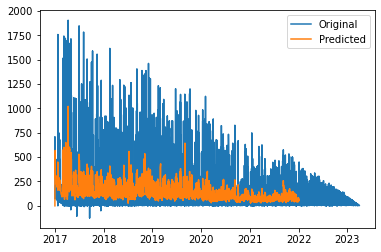

In [20]:
# Plot original data and predicted values
plt.plot(df_trainable.index, df_trainable['Days2'], label='Original')
plt.plot(predicted_values.index, predicted_values, label='Predicted')
plt.legend()
plt.show()

# Attempt 2 - Continuation

In [21]:
name_groups = df.groupby('common_or_proper_name')

In [22]:
name_groups['Days2'].mean()

common_or_proper_name
% 5 Dextrose Injection USP                                                                       125.000000
%10 Dextrose Injection USP (500ml)                                                                35.000000
(hepatitis B vaccine [recombinant])                                                              831.000000
(measles, mumps and rubella virus vaccine, live, attenuated) Lyophilized powder for injection     25.400000
(mirtazapine) Orally Disintegrating Tablets                                                       44.545455
                                                                                                    ...    
vilazodone hydrochloride tablets                                                                  44.500000
vorinostat capsules                                                                               13.000000
warfarin                                                                                          17.000000
zolmit

In [23]:
df_drug_hepatitis = df[df.common_or_proper_name == 'ROSUVASTATIN']

In [24]:
df_drug_hepatitis.head()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3,Days,Days2
139,155654,2438941,Shortage,ACH-ROSUVASTATIN,ACCORD HEALTHCARE INC,ROSUVASTATIN,ROSUVASTATIN,40MG,90,ORAL\r\nORAL,...,NaN,2022-02-25,NaN,2022-05-25,Demand increase for the drug.,2022-02-25,2022-05-26,No,89 days,89
140,161331,2438917,Shortage,ACH-ROSUVASTATIN,ACCORD HEALTHCARE INC,ROSUVASTATIN,ROSUVASTATIN,5MG,90,ORAL\r\nORAL,...,NaN,2022-05-27,2022-06-25,2022-06-28,Demand increase for the drug.,2022-05-26,2022-06-29,No,32 days,32
142,182631,2438925,Shortage,ACH-ROSUVASTATIN,ACCORD HEALTHCARE INC,ROSUVASTATIN,ROSUVASTATIN,10MG,"90, 500",ORAL\r\nORAL,...,NaN,2023-01-23,NaN,2023-03-09,Disruption of the manufacture of the drug.,2023-01-27,2023-03-10,No,45 days,45
144,177039,2438925,Shortage,ACH-ROSUVASTATIN,ACCORD HEALTHCARE INC,ROSUVASTATIN,ROSUVASTATIN,10MG,90,ORAL\r\nORAL,...,NaN,2022-12-02,NaN,2023-01-06,Delay in shipping of the drug.,2022-12-02,2023-01-07,No,35 days,35
145,153311,2438917,Shortage,ACH-ROSUVASTATIN,ACCORD HEALTHCARE INC,ROSUVASTATIN,ROSUVASTATIN,5MG,90,ORAL\r\nORAL,...,NaN,2022-01-21,2022-02-25,2022-02-11,Demand increase for the drug.,2022-01-21,2022-02-12,No,21 days,21


In [25]:
df_drug_hepatitis.shape

(129, 24)

In [26]:
df.actual_start_date.max()

Timestamp('2023-03-31 00:00:00')

In [27]:
df_trainable = df_drug_hepatitis.copy()

In [28]:
df_trainable = df_trainable[['actual_start_date', 'Days2']]

In [29]:
df_trainable.set_index('actual_start_date', inplace=True)

In [30]:
df_drug_hepatitis.actual_start_date.min()

Timestamp('2017-03-10 00:00:00')

In [31]:
df_trainable.sort_index(inplace=True)

In [32]:
df_trainable.shape

(129, 1)

In [33]:
# Split data into training and testing sets
train_data = df_trainable[df_trainable.index < '2022-01-01']['Days2']
test_data = df_trainable[df_trainable.index >= '2022-01-01']['Days2']

In [34]:
# Train ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit()

c:\Users\lucho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
# Make predictions on test data
predicted_values = fitted_model.predict()

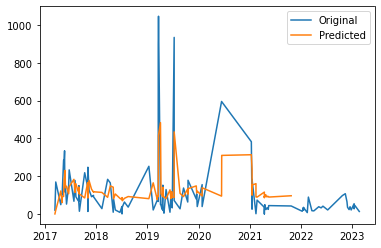

In [36]:
# Plot original data and predicted values
plt.plot(df_trainable.index, df_trainable['Days2'], label='Original')
plt.plot(predicted_values.index, predicted_values, label='Predicted')
plt.legend()
plt.show()